<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/R_SVM_XNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Data directories
train_dir = '/content/drive/MyDrive/DR_50/Train'
test_dir = '/content/drive/MyDrive/DR_50/Test'
valid_dir = '/content/drive/MyDrive/DR_50/Valid'

Mounted at /content/drive


In [3]:
# Image dimensions
img_width, img_height = 300, 300  # Adjust according to your image dimensions
batch_size = 32
num_epochs = 20

In [7]:
# Load VGG16 model for feature extraction
model = Xception(weights='imagenet', include_top=False)

In [8]:
# Function to extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [9]:
# Load images and extract features
x_train, y_train = [], []
for i in range(5):
    class_dir = os.path.join(train_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features(os.path.join(class_dir, img_path))
        x_train.append(features)
        y_train.append(i)


1/1 [==============================] - 0s 255ms/step


In [10]:
# Evaluate on test set
x_test, y_test = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features(os.path.join(class_dir, img_path))
        x_test.append(features)
        y_test.append(i)



1/1 [==============================] - 0s 376ms/step


Training SVM with linear kernel...
Performance metrics for linear kernel:
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.75      0.60      0.67         5
           2       1.00      0.60      0.75         5
           3       0.60      0.60      0.60         5
           4       0.83      1.00      0.91         5

    accuracy                           0.68        25
   macro avg       0.72      0.68      0.69        25
weighted avg       0.72      0.68      0.69        25

Accuracy: 0.68
Sensitivity: 0.6799999999999999
Precision: 0.7223809523809525
F1 Score: 0.6851515151515152



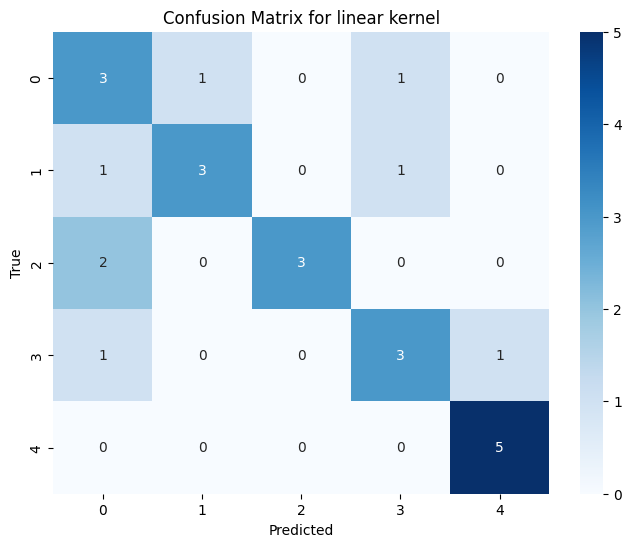

Training SVM with poly kernel...
Performance metrics for poly kernel:
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       1.00      0.40      0.57         5
           2       1.00      0.60      0.75         5
           3       0.38      0.60      0.46         5
           4       0.71      1.00      0.83         5

    accuracy                           0.60        25
   macro avg       0.70      0.60      0.60        25
weighted avg       0.70      0.60      0.60        25

Accuracy: 0.6
Sensitivity: 0.6
Precision: 0.6978571428571428
F1 Score: 0.6032600732600732



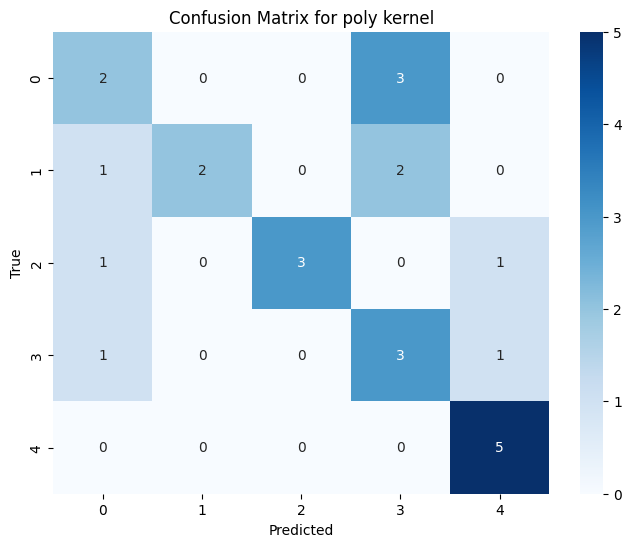

Training SVM with rbf kernel...
Performance metrics for rbf kernel:
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       1.00      0.60      0.75         5
           2       1.00      0.60      0.75         5
           3       0.33      0.40      0.36         5
           4       0.71      1.00      0.83         5

    accuracy                           0.60        25
   macro avg       0.68      0.60      0.61        25
weighted avg       0.68      0.60      0.61        25

Accuracy: 0.6
Sensitivity: 0.6
Precision: 0.6761904761904762
F1 Score: 0.6121212121212121



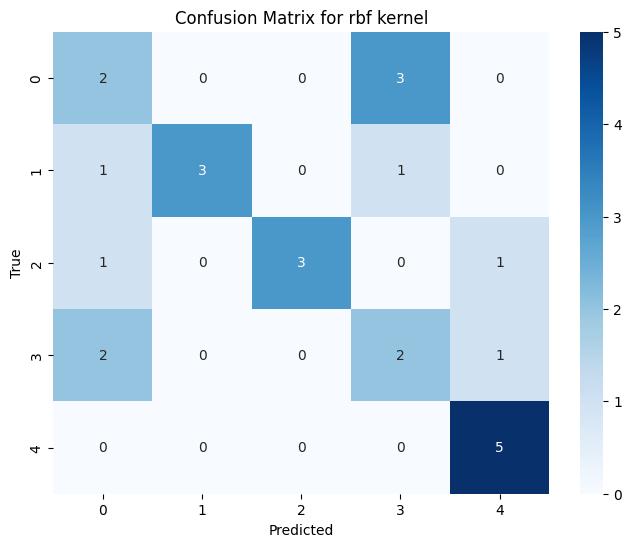

Training SVM with sigmoid kernel...
Performance metrics for sigmoid kernel:
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.80      0.80      0.80         5
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         5
           4       0.50      1.00      0.67         5

    accuracy                           0.52        25
   macro avg       0.54      0.52      0.49        25
weighted avg       0.54      0.52      0.49        25

Accuracy: 0.52
Sensitivity: 0.52
Precision: 0.54
F1 Score: 0.4876190476190477



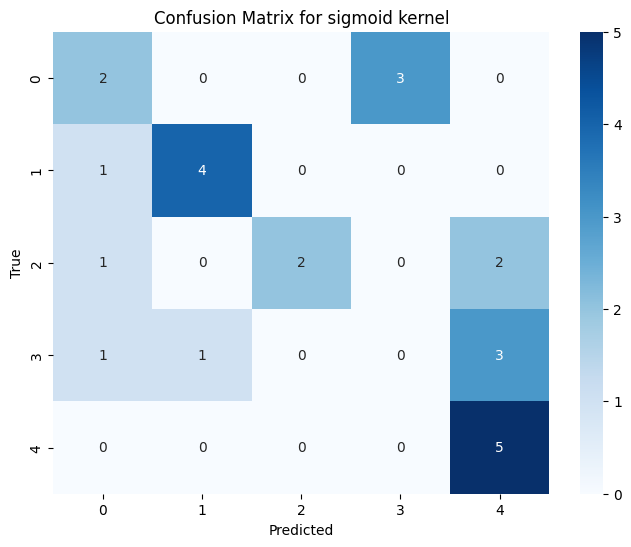

In [13]:
# Flatten the features
x_train_flat = np.array([feature.flatten() for feature in x_train])
x_test_flat = np.array([feature.flatten() for feature in x_test])

# List of kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    print(f"Training SVM with {kernel} kernel...")

    # Train SVM classifier
    clf = svm.SVC(kernel=kernel)
    clf.fit(x_train_flat, y_train)

    # Predict on test set
    y_pred = clf.predict(x_test_flat)


    # Predict on test set
    y_pred = clf.predict(x_test_flat)

    # Print performance metrics
    print(f'Performance metrics for {kernel} kernel:')
    print('Classification Report:')
    print(metrics.classification_report(y_test, y_pred))

    # Additional performance metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    sensitivity = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}\n')

    import seaborn as sns
    import matplotlib.pyplot as plt

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {kernel} kernel')
    plt.show()

